This example illustrates how simple it is to train a classifier using
side information.

It illustrates the exemplary use of the <b>multi-view</b> pattern; for more info
on how to use other patterns, check out the other examples.

In [18]:
from __future__ import print_function

import concarne
import concarne.patterns
import concarne.training

import lasagne
import theano.tensor as T

%pylab inline

try:
    import sklearn.linear_model as sklm
except:
    print (
"""You don't have scikit-learn installed; install it to compare
learning with side information to simple supervised learning""")
    sklm = None

import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Data generation

In [19]:
num_samples = 300

input_dim = 50
side_dim = 50

In [20]:
# generate some random data with 100 samples 
# and 5 dimensions
X = np.random.randn(num_samples, input_dim)

# select the third dimension as the relevant 
# for our classification task
S = X[:, 2:3]

# The labels are simply the sign of S 
# (note the downcast to int32 - this is required 
# by theano)
y = np.asarray(S > 0, dtype='int32').reshape( (-1,) )
# This means we have 2 classes - we will use 
# that later for building the pattern
num_classes = 2


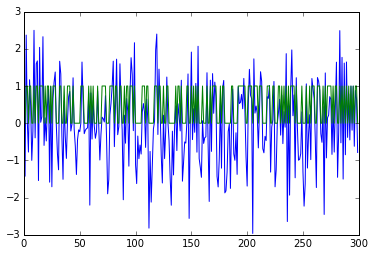

In [21]:
plt.plot(S)
plt.plot(y)

Now let's define some side information: we simulate an additional sensorwhich contains S, but embedded into a different space.

In [22]:
Z = np.random.randn(num_samples, side_dim)
# set second dimension of Z to correspond to S
Z[:, 1] = S[:,0]

Let's make it harder to find S in X and Z by applying a random rotations to both data sets

In [23]:
# random rotation 1
R = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
X = X.dot(R)

# random rotation 2
Q = np.linalg.qr(np.random.randn(side_dim, side_dim))[0]
Z = Z.dot(Q)

Finally, split our data into training, test, and validation data

In [24]:
split = num_samples/3

X_train = X[:split]
X_val = X[split:2*split]
X_test = X[2*split:]

y_train = y[:split]
y_val = y[split:2*split]
y_test = y[2*split:]

Z_train = Z[:split]
Z_val = Z[split:2*split]
Z_test = Z[2*split:]

## Purely supervised learning

Let's check how hard the problem is for supervised learning alone.

In [25]:
if sklm is not None:
    # let's try different regularizations
    for c in [1e-5, 1e-1, 1, 10, 100, 1e5]:
        lr = sklm.LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        print ("Logistic Regression (C=%f)\n accuracy = %.3f %%" % (c, 100*lr.score(X_test, y_test)))

Logistic Regression (C=0.000010)
 accuracy = 78.000 %
Logistic Regression (C=0.100000)
 accuracy = 81.000 %
Logistic Regression (C=1.000000)
 accuracy = 78.000 %
Logistic Regression (C=10.000000)
 accuracy = 79.000 %
Logistic Regression (C=100.000000)
 accuracy = 80.000 %
Logistic Regression (C=100000.000000)
 accuracy = 76.000 %


## Learning with side information: building the pattern


In [26]:
# Let's first define the theano variables which will represent our data
input_var = T.matrix('inputs')  # for X
target_var = T.ivector('targets')  # for Y
side_var = T.matrix('sideinfo')  # for Z


In [27]:
# Size of the intermediate representation phi(X); 
# since S is 1-dim, phi(X) can also map to a 
# 1-dim vector
representation_dim = 1 


Now define the functions - we choose linear functions.

concarne internally relies on lasagne which encodes functions as (sets of) layers. Additionally, concarne supports nolearn style initialization of lasagne layers as follows:


In [28]:
phi = [ (lasagne.layers.DenseLayer, 
         { 'num_units': concarne.patterns.Pattern.PHI_OUTPUT_SHAPE,
         'nonlinearity':None, 'b':None })]
psi = [(lasagne.layers.DenseLayer, 
        { 'num_units': concarne.patterns.Pattern.PSI_OUTPUT_SHAPE, 
        'nonlinearity':lasagne.nonlinearities.softmax, 'b':None })]
beta = [(lasagne.layers.DenseLayer, 
        { 'num_units': concarne.patterns.Pattern.BETA_OUTPUT_SHAPE, 
        'nonlinearity':None, 'b':None })]

For the variable of your layer that denotes the output of the network you should use the markers PHI_OUTPUT_SHAPE,
PSI_OUTPUT_SHAPE and BETA_OUTPUT_SHAPE, so that the pattern can automatically infer the correct shape.


In [29]:
pattern = concarne.patterns.MultiViewPattern(
     phi=phi, psi=psi, beta=beta,
     # the following parameters are required to
     # build the functions and the losses
     input_var=input_var, 
     target_var=target_var, 
     side_var=side_var,
     input_shape=input_dim,
     target_shape=num_classes,
     side_shape=side_dim,
     representation_shape=representation_dim,
     # we have to define two loss functions: 
     # 1) the target loss deals with 
     #    optimizing psi and phi wrt. X & Y
     target_loss=lasagne.objectives.categorical_crossentropy,
     # 2) the side loss deals with 
     #    optimizing beta and phi wrt. X & Z,
     #    for multi-view it is beta(Z)~phi(X)
     side_loss=lasagne.objectives.squared_error)

## Training

To train a pattern, you can use the PatternTrainer which trains the pattern via stochastic gradient descent.
It also supports different procedures to train the pattern. 


In [30]:
trainer = concarne.training.PatternTrainer(
   pattern,
   procedure='simultaneous',
   num_epochs=500,
   batch_size=10,
   update=lasagne.updates.nesterov_momentum,
   update_learning_rate=0.01,
   update_momentum=0.9,
   )

<b>Let's train!</b>

In [31]:
trainer.fit_XYZ(X_train, y_train, [Z_train], 
                X_val=X_val, y_val=y_val, 
                side_val=[X_val, Z_val], 
                verbose=True)
pass

Training procedure: simultaneous
Optimize phi & psi & beta using a weighted sum of target and side objective
 Update: nesterov_momentum(learning_rate=0.01, momentum=0.9) 
   -> standard mode with single training function
Starting training...
Epoch 1 of 500 took 0.004s
  training loss:		1.495710
   (target: 0.355893,  side: 1.139818 (absolute))
  validation loss:		0.703471
  validation accuracy:		49.00 %
  side validation loss:		0.491789
  side validation accuracy:	nan %
Epoch 2 of 500 took 0.005s
  training loss:		0.544633
   (target: 0.346933,  side: 0.197700 (absolute))
  validation loss:		0.697445
  validation accuracy:		50.00 %
  side validation loss:		0.259028
  side validation accuracy:	nan %
Epoch 3 of 500 took 0.004s
  training loss:		0.389688
   (target: 0.344722,  side: 0.044966 (absolute))
  validation loss:		0.694272
  validation accuracy:		52.00 %
  side validation loss:		0.171608
  side validation accuracy:	nan %
Epoch 4 of 500 took 0.004s
  training loss:		0.354294
   (t

Some statistics: Test score.

In [32]:
trainer.score(X_test, y_test, verbose=True)    
pass

Score:
  loss:			0.029269
  accuracy:		99.00 %


We can also compute a test score for the side loss:

In [33]:
trainer.score_side([X_test, Z_test], verbose=True)    
pass

Score for side:
  loss:			0.127295
  accuracy:		nan %


You can then also query the prediction output, similar to the scikit-learn API:

In [34]:
trainer.predict(X_test)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0])